In [30]:
import pandas as pd
import numpy as np
from scipy.sparse import hstack, csr_matrix

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

#for model-building
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D, Input, concatenate

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec

from utils import *

import warnings
warnings.filterwarnings('ignore')

np.random.seed(420)

In [2]:
#load dataset (manually corrected the 12 rows with unmatched column numbers) 

df = pd.read_csv('tiktok_test.csv', on_bad_lines= 'warn')

In [3]:
df.head()

,id,funny,voice_to_text,create_time,share_count,view_count,like_count,comment_count,music_id,username
0,7148933312180997418,1,*sigh* At this point I'll just search anywhere...,1664490756,0,90,3213,31,7148933350202280747,bassaroni765
1,7210048128911740202,1,Like a sweet pierogi. I have leftover pierogi ...,1678720172,0,125,90,1,7013588396048943105,maddy.j.bakes
2,7235292291345468718,1,"When a dog runs around the house, we call it t...",1684597780,1,411,147,1,7232725210447973166,batwesty_2.0
3,7207300528542387499,1,"Okay, so that is actually freaking hysterical,...",1678080443,0,306,39,1,7207300556052876074,pnutbuttercup13
4,7214241311983947051,1,I'd like to direct your attention to the scree...,1679696454,0,46,64,0,7214241297241131822,mirandabickham22


## EDA

In [4]:
print(f'Class Distribution\n', df['funny'].value_counts(), '\n', df['funny'].value_counts()/df.shape[0]*100)

Class Distribution
 0    2060
1     940
Name: funny, dtype: int64 
 0    68.666667
1    31.333333
Name: funny, dtype: float64


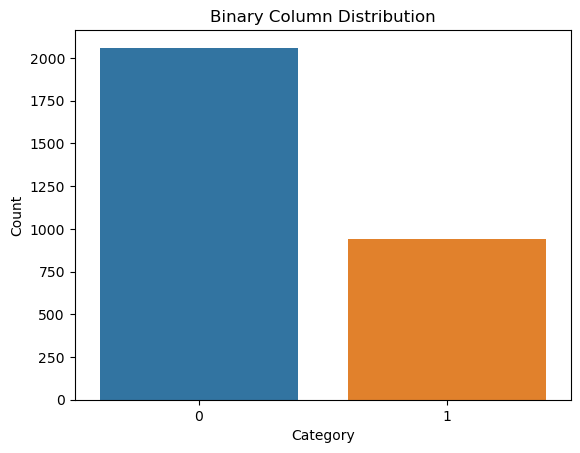

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot using Seaborn
sns.countplot(x='funny', data=df)

# Additional customizations
plt.title('Binary Column Distribution')
plt.xlabel('Category')
plt.ylabel('Count')

# Display the plot
plt.show()

Given the target variable is imbalanced we will use **F1 score** as performance metric.

In [6]:
df.isna().sum()

id               0
funny            0
voice_to_text    0
create_time      0
share_count      0
view_count       0
like_count       0
comment_count    0
music_id         0
username         0
dtype: int64

In [7]:
correlation_matrix = df.corr(numeric_only='False')

correlation_with_target = (correlation_matrix['funny'])
print(correlation_with_target.sort_values(ascending=False)*100)

funny            100.000000
id                 8.072297
create_time        8.071148
comment_count      2.411845
like_count         2.114506
view_count        -0.024732
share_count       -0.189280
music_id          -2.607255
Name: funny, dtype: float64


From the above, I will try create_time, comment_count and like_count as predictors and maybe later drop depending on variable importance.

In [8]:
data = df[['funny', 'voice_to_text', 'create_time', 'comment_count', 'like_count']]

In [9]:
# WORD-COUNT

data.loc[:, 'word_count'] = data['voice_to_text'].apply(lambda x: len(str(x).split()))
print(f'Funny text average word count:', round(data[data['funny']==1]['word_count'].mean(),2))  # Funny
print(f'Not Funny text average word count::', round(data[data['funny']==0]['word_count'].mean(),2))  # Not funny

print(f'Funny text median word count:', round(data[data['funny']==1]['word_count'].median(),2))  # Funny
print(f'Not Funny text median word count::', round(data[data['funny']==0]['word_count'].median(),2))  # Not funny

Funny text average word count: 106.28
Not Funny text average word count:: 159.95
Funny text median word count: 55.0
Not Funny text median word count:: 122.0


On average and in terms of median length, funnier texts tend to be shorter than texts that are not funny. 'word_count' can be used as a predictor as well.

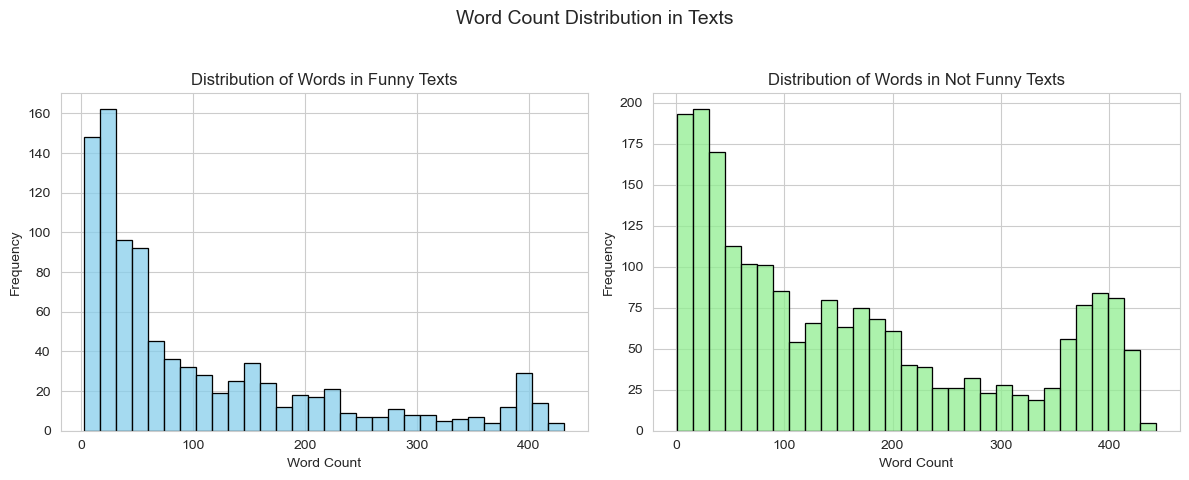

In [10]:
sns.set_style("whitegrid")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plotting 'Funny' word counts
funny_words = data[data['funny'] == 1]['word_count']
sns.histplot(funny_words, ax=ax1, color='skyblue', edgecolor='black', bins=30)
ax1.set_title('Distribution of Words in Funny Texts', fontsize=12)
ax1.set_xlabel('Word Count', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)

# Plotting 'Not Funny' word counts
not_funny_words = data[data['funny'] == 0]['word_count']
sns.histplot(not_funny_words, ax=ax2, color='lightgreen', edgecolor='black', bins=30)
ax2.set_title('Distribution of Words in Not Funny Texts', fontsize=12)
ax2.set_xlabel('Word Count', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)

fig.suptitle('Word Count Distribution in Texts', fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [11]:
# CHARACTER-COUNT

data.loc[:, 'char_count'] = data['voice_to_text'].apply(lambda x: len(str(x)))
print(f'Funny text average character count:', round(data[data['funny']==1]['char_count'].mean(),2))  # Funny
print(f'Not Funny text average character count::', round(data[data['funny']==0]['char_count'].mean(),2))  # Not funny

print(f'Funny text median character count:', round(data[data['funny']==1]['char_count'].median(),2))  # Funny
print(f'Not Funny text median character count::', round(data[data['funny']==0]['char_count'].median(),2))  # Not funny

Funny text average character count: 547.86
Not Funny text average character count:: 834.4
Funny text median character count: 288.0
Not Funny text median character count:: 640.0


Funny text has fewer on average and median characters. Either char_count or word_count can be used as a predictor if need be.

In [12]:
data.corr(numeric_only='False')*100

,funny,create_time,comment_count,like_count,word_count,char_count
funny,100.000000,8.071148,2.411845,2.114506,-19.095517,-19.547040
create_time,8.071148,100.000000,-11.231224,-12.851664,1.209585,0.991902
comment_count,2.411845,-11.231224,100.000000,75.932957,1.029805,1.059116
like_count,2.114506,-12.851664,75.932957,100.000000,-3.449861,-3.437948
word_count,-19.095517,1.209585,1.029805,-3.449861,100.000000,99.648255
char_count,-19.547040,0.991902,1.059116,-3.437948,99.648255,100.000000


## Text Pre-Processing

In [13]:
data['clean_text'] = data['voice_to_text'].apply(lambda x: preprocess_text(x, remove_sw = True, lemmatization=True))
data.head()

,funny,voice_to_text,create_time,comment_count,like_count,word_count,char_count,clean_text
0,1,*sigh* At this point I'll just search anywhere...,1664490756,31,3213,70,357,sigh point ill search anywhere get ta go work ...
1,1,Like a sweet pierogi. I have leftover pierogi ...,1678720172,1,90,197,1043,like sweet pierogi leftover pierogi dough stra...
2,1,"When a dog runs around the house, we call it t...",1684597780,1,147,21,92,dog run around house call zoomies call adhd
3,1,"Okay, so that is actually freaking hysterical,...",1678080443,1,39,290,1487,okay actually freak hysterical babysitter take...
4,1,I'd like to direct your attention to the scree...,1679696454,0,64,49,262,id like direct attention screen short video do...


## Data split and feature selection

In [14]:
# Splitting data into train and test
y = data['funny']
X = data.drop(columns = ['funny', 'voice_to_text'])
X_train_pre, X_test_pre, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

### Feature selection

In [15]:
# for optional features in the dataset, can simply drop any of them or perform pca

pca_set = ['create_time', 'comment_count', 'like_count', 'word_count', 'char_count']
drop_set = ['create_time', 'comment_count', 'like_count', 'word_count']

X_train, X_test = process_data(X_train_pre, X_test_pre, drop=False, pca_features=pca_set, drop_features=drop_set, n_components=2)

X_train.head()

,clean_text,PC1,PC2
0,oh god leo carodon charlie,1.428369,-0.277415
1,really want know april th,1.427514,-0.412071
2,might adhd sudden urge task soon start task su...,1.229207,-0.445569
3,tie dont anything problem anxiety overpower du...,-0.741660,-0.203884
4,hey guy rob day prescribed raw im actually day...,-2.718541,0.059136


## Text Vectorization

In [16]:
# Methods Available: 'tfidf', 'word2vec', 'glove', or 'bert'

# Using Tf-Idf
X_train_vectors_tfidf, tfidf_model = vectorize_text(X_train['clean_text'], method='tfidf')
X_test_vectors_tfidf = tfidf_model.transform(X_test['clean_text'])

In [17]:
# Using Word2Vec
X_train_vectors_word2vec, word2vec_model = vectorize_text(X_train['clean_text'], method='word2vec')

X_test_tokenized = tokenize_texts(X_test['clean_text'])
X_test_vectors_word2vec, _ = vectorize_word2vec(X_test_tokenized, model=word2vec_model)

In [18]:
# Using GloVe
glove_input_file = 'glove.6B.300d.txt' # Adjust this to the correct path
word2vec_output_file = 'glove_to_word2vec.txt'

X_train_vectors_glove, glove_model = vectorize_text(
    texts=X_train['clean_text'], 
    method='glove', 
    glove_input_file=glove_input_file, 
    word2vec_output_file=word2vec_output_file
)

X_test_tokenized = tokenize_texts(X_test['clean_text'])
X_test_vectors_glove, _ = vectorize_glove(X_test_tokenized, model=glove_model)

In [19]:
# # Using BERT
# X_train_vectors_bert, bert_tokenizer, bert_model = vectorize_text(X_train['clean_text'], method='bert')
# X_test_vectors_bert = vectorize_bert(X_test['clean_text'], tokenizer=bert_tokenizer, model=bert_model)

In [20]:
#Run this cell if extra predictors need be added

pca_features_train = X_train[['PC1', 'PC2']].values
pca_features_test = X_test[['PC1', 'PC2']].values

X_train_tfidf = hstack([X_train_vectors_tfidf, csr_matrix(pca_features_train)])
X_test_tfidf = hstack([X_test_vectors_tfidf, csr_matrix(pca_features_test)])

X_train_word2vec = np.column_stack((X_train_vectors_word2vec, pca_features_train))
X_test_word2vec = np.column_stack((X_test_vectors_word2vec, pca_features_test))

X_train_glove = np.column_stack((X_train_vectors_glove, pca_features_train))
X_test_glove = np.column_stack((X_test_vectors_glove, pca_features_test))

# X_train_bert['char_count'] = X_train['char_count'].values
# X_test_bert['char_count'] = X_test['char_count'].values

## Classification Models

#### Logistic Regression with GridSearch

In [21]:
param_grid_lr = {'C': np.logspace(-2, 1, 20), 'penalty': ['l1', 'l2']}
lr_model = LogisticRegression(solver='liblinear')
lr_grid = GridSearchCV(lr_model, param_grid_lr, scoring='f1', cv=5)

# Using Tf-Idf
print_separator("Logistic Regression with Tf-Idf")
lr_grid.fit(X_train_tfidf, y_train)
print("Best Parameters:", lr_grid.best_params_)
print("Evaluating on Tf-Idf test set...")
y_pred_lr = lr_grid.best_estimator_.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr, average='binary'))

# Using Word2Vec
print_separator("Logistic Regression with Word2Vec")
lr_grid.fit(X_train_word2vec, y_train)
print("Best Parameters:", lr_grid.best_params_)
print("Evaluating on Word2Vec test set...")
y_pred_word2vec = lr_grid.best_estimator_.predict(X_test_word2vec)
print(classification_report(y_test, y_pred_word2vec))
print("Accuracy:", accuracy_score(y_test, y_pred_word2vec))
print("F1 Score:", f1_score(y_test, y_pred_word2vec, average='binary'))

# Using GloVe
print_separator("Logistic Regression with GloVe")
lr_grid.fit(X_train_glove, y_train)
print("Best Parameters:", lr_grid.best_params_)
print("Evaluating on GloVe test set...")
y_pred_glove = lr_grid.best_estimator_.predict(X_test_glove)
print(classification_report(y_test, y_pred_glove))
print("Accuracy:", accuracy_score(y_test, y_pred_glove))
print("F1 Score:", f1_score(y_test, y_pred_glove, average='binary'))

# # Using BERT
# print_separator("Logistic Regression with BERT")
# lr_grid.fit(X_train_bert, y_train)
# print("Best Parameters:", lr_grid.best_params_)
# print("Evaluating on BERT test set...")
# y_pred_bert = lr_grid.best_estimator_.predict(X_test_bert)
# print(classification_report(y_test, y_pred_bert))
# print("Accuracy:", accuracy_score(y_test, y_pred_bert))
# print("F1 Score:", f1_score(y_test, y_pred_bert, average='binary'))


         Logistic Regression with Tf-Idf          
Best Parameters: {'C': 4.832930238571752, 'penalty': 'l1'}
Evaluating on Tf-Idf test set...
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       417
           1       0.52      0.42      0.47       183

    accuracy                           0.71       600
   macro avg       0.64      0.63      0.63       600
weighted avg       0.69      0.71      0.70       600

Accuracy: 0.7066666666666667
F1 Score: 0.46666666666666673

        Logistic Regression with Word2Vec         
Best Parameters: {'C': 10.0, 'penalty': 'l1'}
Evaluating on Word2Vec test set...
              precision    recall  f1-score   support

           0       0.70      0.93      0.80       417
           1       0.40      0.10      0.17       183

    accuracy                           0.68       600
   macro avg       0.55      0.52      0.48       600
weighted avg       0.61      0.68      0.61       600

Accuracy: 

#### SVM with GridSearch

In [22]:
param_grid_svm = {
    'C': np.logspace(-2, 1, 20),
    'kernel': ['linear', 'rbf', 'poly']
}
svm_model = SVC()
svm_grid = GridSearchCV(svm_model, param_grid_svm, scoring='f1', cv=5)

# Using Tf-Idf
print_separator("SVM with Tf-Idf")
svm_grid.fit(X_train_tfidf, y_train)
print("Best Parameters:", svm_grid.best_params_)
print("Evaluating SVM on Tf-Idf test set...")
y_pred_svm = svm_grid.best_estimator_.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("F1 Score:", f1_score(y_test, y_pred_svm, average='binary'))

# Using Word2Vec
print_separator("SVM with Word2Vec")
svm_grid.fit(X_train_word2vec, y_train)
print("Best Parameters:", svm_grid.best_params_)
y_pred_word2vec = svm_grid.best_estimator_.predict(X_test_word2vec)
print(classification_report(y_test, y_pred_word2vec))
print("Accuracy:", accuracy_score(y_test, y_pred_word2vec))
print("F1 Score:", f1_score(y_test, y_pred_word2vec, average='binary'))

# Using GloVe
print_separator("SVM with GloVe")
svm_grid.fit(X_train_glove, y_train)
print("Best Parameters:", svm_grid.best_params_)
y_pred_glove = svm_grid.best_estimator_.predict(X_test_glove)
print(classification_report(y_test, y_pred_glove))
print("Accuracy:", accuracy_score(y_test, y_pred_glove))
print("F1 Score:", f1_score(y_test, y_pred_glove, average='binary'))

# # Using BERT
# print_separator("SVM with BERT")
# svm_grid.fit(X_train_bert, y_train)
# print("Best Parameters:", svm_grid.best_params_)
# y_pred_bert = svm_grid.best_estimator_.predict(X_test_bert)
# print(classification_report(y_test, y_pred_bert))
# print("Accuracy:", accuracy_score(y_test, y_pred_bert))
# print("F1 Score:", f1_score(y_test, y_pred_bert, average='binary'))


                 SVM with Tf-Idf                  
Best Parameters: {'C': 2.3357214690901213, 'kernel': 'linear'}
Evaluating SVM on Tf-Idf test set...
              precision    recall  f1-score   support

           0       0.76      0.79      0.78       417
           1       0.48      0.43      0.45       183

    accuracy                           0.68       600
   macro avg       0.62      0.61      0.62       600
weighted avg       0.67      0.68      0.68       600

Accuracy: 0.6833333333333333
F1 Score: 0.45402298850574707

                SVM with Word2Vec                 
Best Parameters: {'C': 10.0, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.70      0.99      0.82       417
           1       0.40      0.01      0.02       183

    accuracy                           0.69       600
   macro avg       0.55      0.50      0.42       600
weighted avg       0.61      0.69      0.58       600

Accuracy: 0.6933333333333334
F1 Score

#### XGBoost with GridSearch

In [23]:
param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.5, 1]
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_grid = GridSearchCV(xgb_model, param_grid_xgb, scoring='f1', cv=5)

# Using Tf-Idf
print_separator("XGBoost with Tf-Idf")
xgb_grid.fit(X_train_tfidf, y_train)
print("Best Parameters:", xgb_grid.best_params_)
print("Evaluating XGBoost on Tf-Idf test set...")
y_pred_xgb_tfidf = xgb_grid.best_estimator_.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_xgb_tfidf))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb_tfidf))
print("F1 Score:", f1_score(y_test, y_pred_xgb_tfidf, average='binary'))

# Using Word2Vec
print_separator("XGBoost with Word2Vec")
xgb_grid.fit(X_train_word2vec, y_train)
print("Best Parameters:", xgb_grid.best_params_)
y_pred_xgb_word2vec = xgb_grid.best_estimator_.predict(X_test_word2vec)
print(classification_report(y_test, y_pred_xgb_word2vec))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb_word2vec))
print("F1 Score:", f1_score(y_test, y_pred_xgb_word2vec, average='binary'))

# Using GloVe
print_separator("XGBoost with GloVe")
xgb_grid.fit(X_train_glove, y_train)
print("Best Parameters:", xgb_grid.best_params_)
y_pred_xgb_glove = xgb_grid.best_estimator_.predict(X_test_glove)
print(classification_report(y_test, y_pred_xgb_glove))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb_glove))
print("F1 Score:", f1_score(y_test, y_pred_xgb_glove, average='binary'))

# # Using BERT
# print_separator("XGBoost with BERT")
# xgb_grid.fit(X_train_bert, y_train)
# print("Best Parameters:", xgb_grid.best_params_)
# y_pred_xgb_bert = xgb_grid.best_estimator_.predict(X_test_bert)
# print(classification_report(y_test, y_pred_xgb_bert))
# print("Accuracy:", accuracy_score(y_test, y_pred_xgb_bert))
# print("F1 Score:", f1_score(y_test, y_pred_xgb_bert, average='binary'))


               XGBoost with Tf-Idf                
Best Parameters: {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 200}
Evaluating XGBoost on Tf-Idf test set...
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       417
           1       0.53      0.41      0.46       183

    accuracy                           0.71       600
   macro avg       0.65      0.63      0.63       600
weighted avg       0.69      0.71      0.70       600

Accuracy: 0.71
F1 Score: 0.46296296296296297

              XGBoost with Word2Vec               
Best Parameters: {'learning_rate': 1, 'max_depth': 3, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       417
           1       0.53      0.41      0.46       183

    accuracy                           0.71       600
   macro avg       0.65      0.62      0.63       600
weighted avg       0.69      0.71      0.70       600

Accu

#### Ensemble Model using VotingClassifier

In [24]:
clf1 = RandomForestClassifier(n_estimators=100)
clf2 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf3 = SVC(probability=True, kernel='linear')

# Ensemble model - VotingClassifier soft
ensemble_model = VotingClassifier(estimators=[('rf', clf1), ('XGBC', clf2), ('svm', clf3)], voting='soft')

# Using Tf-Idf
print_separator("Ensemble Model with Tf-Idf")
ensemble_model.fit(X_train_tfidf, y_train)
print("Evaluating Ensemble Model on Tf-Idf test set...")
y_pred_ensemble_tfidf = ensemble_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_ensemble_tfidf))
print("Accuracy:", accuracy_score(y_test, y_pred_ensemble_tfidf))
print("F1 Score:", f1_score(y_test, y_pred_ensemble_tfidf, average='binary'))

# Using Word2Vec
print_separator("Ensemble Model with Word2Vec")
ensemble_model.fit(X_train_word2vec, y_train)
print("Evaluating Ensemble Model on Word2Vec test set...")
y_pred_ensemble_word2vec = ensemble_model.predict(X_test_word2vec)
print(classification_report(y_test, y_pred_ensemble_word2vec))
print("Accuracy:", accuracy_score(y_test, y_pred_ensemble_word2vec))
print("F1 Score:", f1_score(y_test, y_pred_ensemble_word2vec, average='binary'))

# Using GloVe
print_separator("Ensemble Model with GloVe")
ensemble_model.fit(X_train_glove, y_train)
print("Evaluating Ensemble Model on GloVe test set...")
y_pred_ensemble_glove = ensemble_model.predict(X_test_glove)
print(classification_report(y_test, y_pred_ensemble_glove))
print("Accuracy:", accuracy_score(y_test, y_pred_ensemble_glove))
print("F1 Score:", f1_score(y_test, y_pred_ensemble_glove, average='binary'))

# # Using BERT
# print_separator("Ensemble Model with BERT")
# ensemble_model.fit(X_train_bert, y_train)
# print("Evaluating Ensemble Model on BERT test set...")
# y_pred_ensemble_bert = ensemble_model.predict(X_test_bert)
# print(classification_report(y_test, y_pred_ensemble_bert))
# print("Accuracy:", accuracy_score(y_test, y_pred_ensemble_bert))
# print("F1 Score:", f1_score(y_test, y_pred_ensemble_bert, average='binary'))


            Ensemble Model with Tf-Idf            
Evaluating Ensemble Model on Tf-Idf test set...
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       417
           1       0.60      0.28      0.38       183

    accuracy                           0.72       600
   macro avg       0.67      0.60      0.60       600
weighted avg       0.70      0.72      0.69       600

Accuracy: 0.7233333333333334
F1 Score: 0.3805970149253731

           Ensemble Model with Word2Vec           
Evaluating Ensemble Model on Word2Vec test set...
              precision    recall  f1-score   support

           0       0.74      0.93      0.82       417
           1       0.61      0.25      0.36       183

    accuracy                           0.72       600
   macro avg       0.67      0.59      0.59       600
weighted avg       0.70      0.72      0.68       600

Accuracy: 0.7216666666666667
F1 Score: 0.3552123552123552

            Ensemble Model 

In [25]:
clf1 = RandomForestClassifier(n_estimators=100)
clf2 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf3 = SVC(probability=True, kernel='linear')

# Ensemble model - VotingClassifier hard
ensemble_model = VotingClassifier(estimators=[('rf', clf1), ('XGBC', clf2), ('svm', clf3)], voting='hard')

# Using Tf-Idf
print_separator("Ensemble Model with Tf-Idf")
ensemble_model.fit(X_train_tfidf, y_train)
print("Evaluating Ensemble Model on Tf-Idf test set...")
y_pred_ensemble_tfidf = ensemble_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_ensemble_tfidf))
print("Accuracy:", accuracy_score(y_test, y_pred_ensemble_tfidf))
print("F1 Score:", f1_score(y_test, y_pred_ensemble_tfidf, average='binary'))

# Using Word2Vec
print_separator("Ensemble Model with Word2Vec")
ensemble_model.fit(X_train_word2vec, y_train)
print("Evaluating Ensemble Model on Word2Vec test set...")
y_pred_ensemble_word2vec = ensemble_model.predict(X_test_word2vec)
print(classification_report(y_test, y_pred_ensemble_word2vec))
print("Accuracy:", accuracy_score(y_test, y_pred_ensemble_word2vec))
print("F1 Score:", f1_score(y_test, y_pred_ensemble_word2vec, average='binary'))

# Using GloVe
print_separator("Ensemble Model with GloVe")
ensemble_model.fit(X_train_glove, y_train)
print("Evaluating Ensemble Model on GloVe test set...")
y_pred_ensemble_glove = ensemble_model.predict(X_test_glove)
print(classification_report(y_test, y_pred_ensemble_glove))
print("Accuracy:", accuracy_score(y_test, y_pred_ensemble_glove))
print("F1 Score:", f1_score(y_test, y_pred_ensemble_glove, average='binary'))

# # Using BERT
# print_separator("Ensemble Model with BERT")
# ensemble_model.fit(X_train_bert, y_train)
# print("Evaluating Ensemble Model on BERT test set...")
# y_pred_ensemble_bert = ensemble_model.predict(X_test_bert)
# print(classification_report(y_test, y_pred_ensemble_bert))
# print("Accuracy:", accuracy_score(y_test, y_pred_ensemble_bert))
# print("F1 Score:", f1_score(y_test, y_pred_ensemble_bert, average='binary'))


            Ensemble Model with Tf-Idf            
Evaluating Ensemble Model on Tf-Idf test set...
              precision    recall  f1-score   support

           0       0.74      0.91      0.82       417
           1       0.57      0.26      0.35       183

    accuracy                           0.71       600
   macro avg       0.65      0.59      0.58       600
weighted avg       0.68      0.71      0.67       600

Accuracy: 0.7133333333333334
F1 Score: 0.3533834586466166

           Ensemble Model with Word2Vec           
Evaluating Ensemble Model on Word2Vec test set...
              precision    recall  f1-score   support

           0       0.75      0.95      0.83       417
           1       0.69      0.26      0.38       183

    accuracy                           0.74       600
   macro avg       0.72      0.60      0.61       600
weighted avg       0.73      0.74      0.70       600

Accuracy: 0.7383333333333333
F1 Score: 0.3794466403162055

            Ensemble Model 

#### CNN using keras

In [32]:
def cnn_model0(input_shape, num_filters, kernel_size):
    model = Sequential()
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Model parameters
num_filters = 64
kernel_size = 3

# Using Tf-Idf
print_separator("CNN with Tf-Idf")
input_shape = (X_train_tfidf.shape[1], 1)  # Adjust the input shape for Conv1D
X_train_tfidf_reshaped = np.expand_dims(X_train_tfidf.toarray(), axis=-1)
X_test_tfidf_reshaped = np.expand_dims(X_test_tfidf.toarray(), axis=-1)
model_tfidf = cnn_model0(input_shape, num_filters, kernel_size)
model_tfidf.fit(X_train_tfidf_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.1)
loss_tfidf, accuracy_tfidf = model_tfidf.evaluate(X_test_tfidf_reshaped, y_test)
print(f'Tf-Idf Test Loss: {loss_tfidf:.4f}, Test Accuracy: {accuracy_tfidf:.4f}')


                 CNN with Tf-Idf                  
Epoch 1/10
68/68 [==============================] - 17s 218ms/step - loss: 0.6568 - accuracy: 0.6597 - val_loss: 0.6327 - val_accuracy: 0.6625
Epoch 2/10
68/68 [==============================] - 14s 211ms/step - loss: 0.6194 - accuracy: 0.6866 - val_loss: 0.6315 - val_accuracy: 0.6625
Epoch 3/10
68/68 [==============================] - 16s 233ms/step - loss: 0.6142 - accuracy: 0.6861 - val_loss: 0.6275 - val_accuracy: 0.6625
Epoch 4/10
68/68 [==============================] - 15s 216ms/step - loss: 0.6122 - accuracy: 0.6875 - val_loss: 0.6288 - val_accuracy: 0.6625
Epoch 5/10
68/68 [==============================] - 14s 213ms/step - loss: 0.6098 - accuracy: 0.6866 - val_loss: 0.6292 - val_accuracy: 0.6625
Epoch 6/10
68/68 [==============================] - 15s 217ms/step - loss: 0.6057 - accuracy: 0.6866 - val_loss: 0.6280 - val_accuracy: 0.6625
Epoch 7/10
68/68 [==============================] - 14s 207ms/step - loss: 0.6072 - accura

In [28]:
def cnn_model1(input_shape, num_filters, kernel_size):
    model = Sequential()
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define model parameters
num_filters = 64
kernel_size = 3

X_train_reshaped_word2vec = np.expand_dims(X_train_word2vec, axis=-1)
X_test_reshaped_word2vec = np.expand_dims(X_test_word2vec, axis=-1)

# Using Word2Vec
print_separator("CNN with Word2Vec")
input_shape_word2vec = (X_train_word2vec.shape[1], 1)
model_word2vec = cnn_model1(input_shape_word2vec, num_filters, kernel_size)
model_word2vec.fit(X_train_reshaped_word2vec, y_train, epochs=10, batch_size=32, validation_split=0.1)
loss_word2vec, accuracy_word2vec = model_word2vec.evaluate(X_test_reshaped_word2vec, y_test)
print(f'Word2Vec Test Loss: {loss_word2vec:.4f}, Test Accuracy: {accuracy_word2vec:.4f}')

# Reshape GloVe data
X_train_reshaped_glove = np.expand_dims(X_train_glove, axis=-1)
X_test_reshaped_glove = np.expand_dims(X_test_glove, axis=-1)

# Using GloVe
print_separator("CNN with GloVe")
input_shape_glove = (X_train_glove.shape[1], 1)
model_glove = cnn_model1(input_shape_glove, num_filters, kernel_size)
model_glove.fit(X_train_reshaped_glove, y_train, epochs=10, batch_size=32, validation_split=0.1)
loss_glove, accuracy_glove = model_glove.evaluate(X_test_reshaped_glove, y_test)
print(f'GloVe Test Loss: {loss_glove:.4f}, Test Accuracy: {accuracy_glove:.4f}')

# # Using BERT
# print_separator("CNN with BERT")
# model_bert = cnn_model(X_train_bert.shape[1], num_filters, kernel_size, embedding_dim)
# model_bert.fit(X_train_bert, y_train, epochs=10, batch_size=32, validation_split=0.1)
# loss_bert, accuracy_bert = model_bert.evaluate(X_test_bert, y_test)
# print(f'BERT Test Loss: {loss_bert:.4f}, Test Accuracy: {accuracy_bert:.4f}')


                CNN with Word2Vec                 
Epoch 1/10
68/68 [==============================] - 5s 20ms/step - loss: 0.6490 - accuracy: 0.6620 - val_loss: 0.6388 - val_accuracy: 0.6625
Epoch 2/10
68/68 [==============================] - 1s 10ms/step - loss: 0.6325 - accuracy: 0.6852 - val_loss: 0.6351 - val_accuracy: 0.6625
Epoch 3/10
68/68 [==============================] - 1s 13ms/step - loss: 0.6280 - accuracy: 0.6880 - val_loss: 0.6341 - val_accuracy: 0.6625
Epoch 4/10
68/68 [==============================] - 1s 9ms/step - loss: 0.6303 - accuracy: 0.6875 - val_loss: 0.6332 - val_accuracy: 0.6583
Epoch 5/10
68/68 [==============================] - 1s 10ms/step - loss: 0.6252 - accuracy: 0.6870 - val_loss: 0.6332 - val_accuracy: 0.6583
Epoch 6/10
68/68 [==============================] - 1s 10ms/step - loss: 0.6212 - accuracy: 0.6861 - val_loss: 0.6314 - val_accuracy: 0.6583
Epoch 7/10
68/68 [==============================] - 1s 10ms/step - loss: 0.6154 - accuracy: 0.6875 - va

#### CNN Trial

In [31]:
def cnn_model2(input_shape, num_filters, kernel_sizes, dropout_rate=0.5):
    input_layer = Input(shape=input_shape)
    conv_layers = []

    for kernel_size in kernel_sizes:
        conv_layer = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')(input_layer)
        pooling_layer = GlobalMaxPooling1D()(conv_layer)
        conv_layers.append(pooling_layer)

    concatenated = concatenate(conv_layers, axis=-1) if len(conv_layers) > 1 else conv_layers[0]

    dense_layer_1 = Dense(64, activation='relu')(concatenated)
    dropout_1 = Dropout(dropout_rate)(dense_layer_1)
    dense_layer_2 = Dense(32, activation='relu')(dropout_1)
    dropout_2 = Dropout(dropout_rate)(dense_layer_2)
    output_layer = Dense(1, activation='sigmoid')(dropout_2)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Model parameters
num_filters = 64
kernel_sizes = [3, 4, 5]
dropout_rate = 0.5

# Using Tf-Idf
print_separator("CNN with Multiple Kernels - Tf-Idf")
input_shape = (X_train_tfidf.shape[1], 1)  # Adjust the input shape for Conv1D
X_train_tfidf_reshaped = np.expand_dims(X_train_tfidf.toarray(), axis=-1)
X_test_tfidf_reshaped = np.expand_dims(X_test_tfidf.toarray(), axis=-1)
model_tfidf = cnn_model2(input_shape, num_filters, kernel_sizes, dropout_rate)
model_tfidf.fit(X_train_tfidf_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.1)
loss_tfidf, accuracy_tfidf = model_tfidf.evaluate(X_test_tfidf_reshaped, y_test)
print(f'Tf-Idf Test Loss: {loss_tfidf:.4f}, Test Accuracy: {accuracy_tfidf:.4f}')

# Using Word2Vec
print_separator("CNN with Multiple Kernels - Word2Vec")
input_shape_word2vec = (X_train_word2vec.shape[1], 1)
model_word2vec = cnn_model2(input_shape_word2vec, num_filters, kernel_sizes, dropout_rate)
model_word2vec.fit(np.expand_dims(X_train_word2vec, axis=-1), y_train, epochs=10, batch_size=32, validation_split=0.1)
loss_word2vec, accuracy_word2vec = model_word2vec.evaluate(np.expand_dims(X_test_word2vec, axis=-1), y_test)
print(f'Word2Vec Test Loss: {loss_word2vec:.4f}, Test Accuracy: {accuracy_word2vec:.4f}')

# Using GloVe
print_separator("CNN with Multiple Kernels - GloVe")
input_shape_glove = (X_train_glove.shape[1], 1)
model_glove = cnn_model2(input_shape_glove, num_filters, kernel_sizes, dropout_rate)
model_glove.fit(np.expand_dims(X_train_glove, axis=-1), y_train, epochs=10, batch_size=32, validation_split=0.1)
loss_glove, accuracy_glove = model_glove.evaluate(np.expand_dims(X_test_glove, axis=-1), y_test)
print(f'GloVe Test Loss: {loss_glove:.4f}, Test Accuracy: {accuracy_glove:.4f}')


        CNN with Multiple Kernels - Tf-Idf        
Epoch 1/10
68/68 [==============================] - 77s 939ms/step - loss: 0.6550 - accuracy: 0.6384 - val_loss: 0.6302 - val_accuracy: 0.6625
Epoch 2/10
68/68 [==============================] - 64s 940ms/step - loss: 0.6217 - accuracy: 0.6861 - val_loss: 0.6300 - val_accuracy: 0.6625
Epoch 3/10
68/68 [==============================] - 65s 958ms/step - loss: 0.6171 - accuracy: 0.6852 - val_loss: 0.6275 - val_accuracy: 0.6625
Epoch 4/10
68/68 [==============================] - 66s 973ms/step - loss: 0.6067 - accuracy: 0.6861 - val_loss: 0.6268 - val_accuracy: 0.6625
Epoch 5/10
68/68 [==============================] - 64s 943ms/step - loss: 0.6166 - accuracy: 0.6861 - val_loss: 0.6283 - val_accuracy: 0.6625
Epoch 6/10
68/68 [==============================] - 65s 960ms/step - loss: 0.6109 - accuracy: 0.6856 - val_loss: 0.6274 - val_accuracy: 0.6625
Epoch 7/10
68/68 [==============================] - 51s 745ms/step - loss: 0.6044 - accura

## Analysis

In [33]:
clf1 = RandomForestClassifier(n_estimators=100)
clf2 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf3 = SVC(probability=True, kernel='linear')

# Ensemble model - VotingClassifier soft
final_model = VotingClassifier(estimators=[('rf', clf1), ('XGBC', clf2), ('svm', clf3)], voting='soft')

# Using GloVe
print_separator("Ensemble Model with GloVe")
final_model.fit(X_train_glove, y_train)
print("Evaluating Ensemble Model on GloVe test set...")
y_pred_ensemble_glove = final_model.predict(X_test_glove)
print(classification_report(y_test, y_pred_ensemble_glove))
print("Accuracy:", accuracy_score(y_test, y_pred_ensemble_glove))
print("F1 Score:", f1_score(y_test, y_pred_ensemble_glove, average='binary'))


            Ensemble Model with GloVe             
Evaluating Ensemble Model on GloVe test set...
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       417
           1       0.63      0.39      0.48       183

    accuracy                           0.74       600
   macro avg       0.70      0.65      0.66       600
weighted avg       0.73      0.74      0.73       600

Accuracy: 0.745
F1 Score: 0.48484848484848486


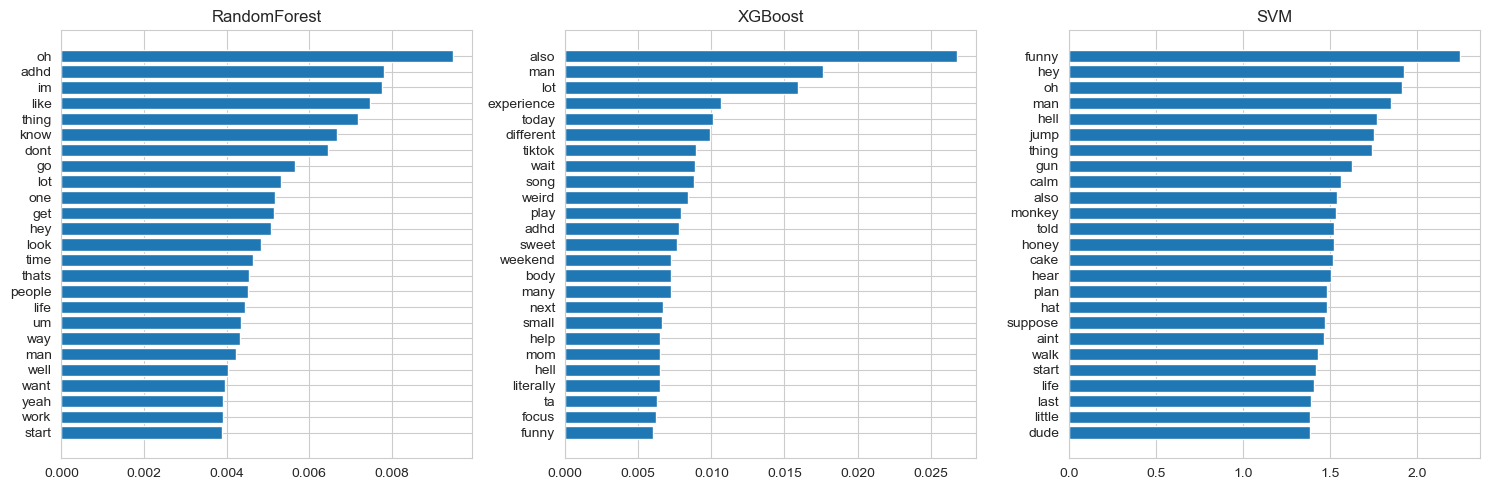

In [35]:
clf1 = RandomForestClassifier(n_estimators=100)
clf2 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf3 = SVC(probability=True, kernel='linear')

clf1.fit(X_train_vectors_tfidf, y_train)  # RandomForest
clf2.fit(X_train_vectors_tfidf, y_train)  # XGBoost
clf3.fit(X_train_vectors_tfidf, y_train)  # SVM

feature_importance_rf = clf1.feature_importances_
feature_importance_xgb = clf2.feature_importances_
feature_importance_svm = np.abs(clf3.coef_.toarray()[0])

# feature names from tf-idf
feature_names = tfidf_model.get_feature_names_out()

importance_rf = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance_rf})
importance_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance_xgb})
importance_svm = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance_svm})

# Sort by importance
importance_rf = importance_rf.sort_values(by='Importance', ascending=False)
importance_xgb = importance_xgb.sort_values(by='Importance', ascending=False)
importance_svm = importance_svm.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.barh(importance_rf['Feature'][:25], importance_rf['Importance'][:25])
plt.gca().invert_yaxis()
plt.title('RandomForest')

plt.subplot(1, 3, 2)
plt.barh(importance_xgb['Feature'][:25], importance_xgb['Importance'][:25])
plt.gca().invert_yaxis()
plt.title('XGBoost')

plt.subplot(1, 3, 3)
plt.barh(importance_svm['Feature'][:25], importance_svm['Importance'][:25])
plt.gca().invert_yaxis()
plt.title('SVM')

plt.tight_layout()
plt.show()

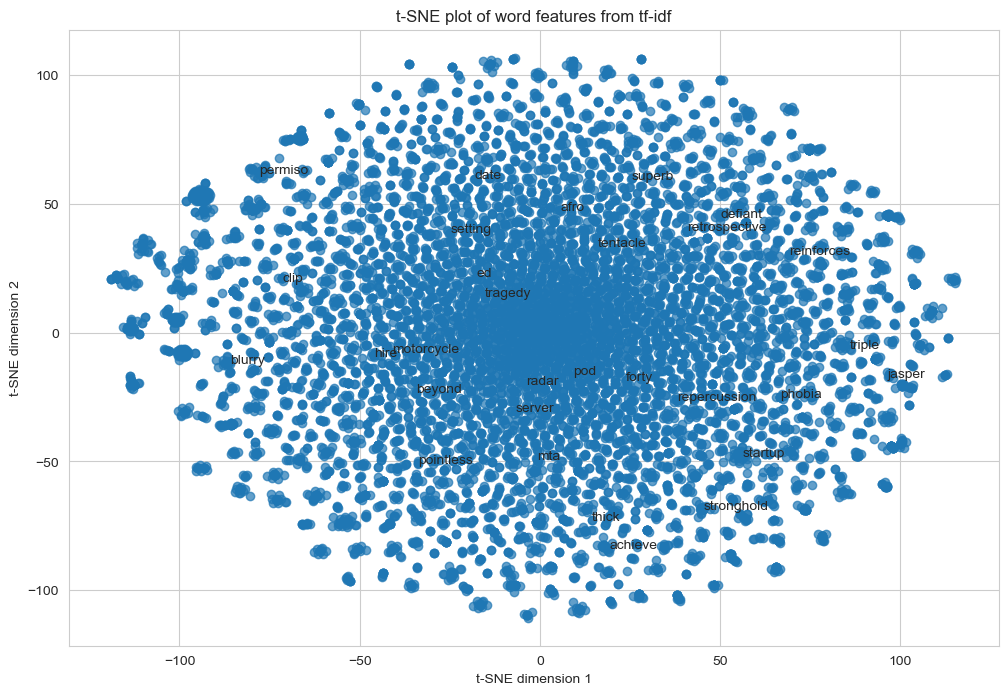

In [34]:
word_features = X_train_vectors_tfidf.T

# Perform t-SNE on word features
tsne = TSNE(n_components=2, random_state=0)
word_features_tsne = tsne.fit_transform(word_features.toarray())

# Create a DataFrame for plotting
words = tfidf_model.get_feature_names_out()
word_features_df = pd.DataFrame(word_features_tsne, index=words, columns=['x', 'y'])

# Plotting
plt.figure(figsize=(12, 8))
plt.scatter(word_features_df['x'], word_features_df['y'], alpha=0.7)

# Optionally, annotate some words to see which ones they are
for word in words[np.random.choice(len(words), 30, replace=False)]:  # randomly select 30 words
    plt.annotate(word, (word_features_df.loc[word, 'x'], word_features_df.loc[word, 'y']))

plt.title('t-SNE plot of word features from tf-idf')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

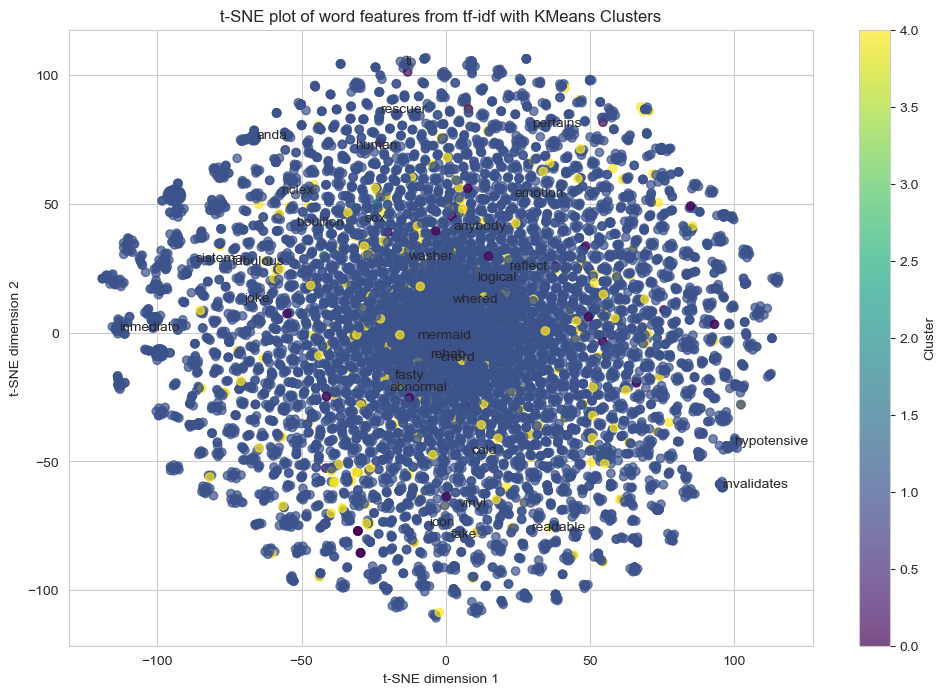

In [48]:
from sklearn.cluster import KMeans

word_features = X_train_vectors_tfidf.T.toarray()

# Perform t-SNE on word features
tsne = TSNE(n_components=2, random_state=0)
word_features_tsne = tsne.fit_transform(word_features)

# Create a DataFrame for plotting
words = tfidf_model.get_feature_names_out()
word_features_df = pd.DataFrame(word_features_tsne, index=words, columns=['x', 'y'])

# KMeans Clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(word_features)
word_clusters = kmeans.labels_

# Create DataFrame for clusters
cluster_df = pd.DataFrame({'Word': words, 'Cluster': word_clusters})

# Plotting t-SNE with clusters
plt.figure(figsize=(12, 8))
plt.scatter(word_features_df['x'], word_features_df['y'], c=word_clusters, cmap='viridis', alpha=0.7)

# Optionally, annotate some words to see which ones they are
for word in words[np.random.choice(len(words), 30, replace=False)]:  # randomly select 30 words
    plt.annotate(word, (word_features_df.loc[word, 'x'], word_features_df.loc[word, 'y']))

plt.title('t-SNE plot of word features from tf-idf with KMeans Clusters')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.colorbar(label='Cluster')
plt.show()